In [1]:
import os
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
from keras.layers import Dense, Dropout, Flatten, Normalization, Conv1D, MaxPool1D, LSTM, Conv2D, MaxPool2D
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import tensorflow as tf
tf.config.run_functions_eagerly(True)



2023-11-13 14:31:32.051062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 14:31:32.051112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 14:31:32.051141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 14:31:32.059405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# our usual useful functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")

In [3]:
x_d = np.load('xtrain.npy')
y_num = np.load('ytrain_num.npy')
y_gender = np.load('ytrain_gender.npy')
x_s = np.load('x_spectrum_train.npy')


In [4]:
def spectrum_data(audio_tracks):
    X = np.empty((25000,128, 128))
    for i, audio_track in enumerate(tqdm(audio_tracks)):        
        f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
        Zxx_ = np.abs(Zxx[0:227, 2:-1])
        Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
        Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)
        Zxx_ = resize(Zxx_, (1, 128, 128))
        X[i] = Zxx_
    return X



In [4]:
def prepare_data(X,Y):
    X_train, X_validation, Y_train, Y_validation = sklearn.model_selection.train_test_split(X, Y, test_size=.1)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train = one_hot_encoder.fit_transform(Y_train.reshape(-1, 1))
    Y_validation = one_hot_encoder.fit_transform(Y_validation.reshape(-1, 1))
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 128, 1)
    X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 128, 1)
    return X_train, X_validation, Y_train, Y_validation

#X_train, X_validation, Y_train, Y_validation = prepare_data(x_d, y_gender)
X_train_spectrum, X_validation_spectrum, Y_train, Y_validation = prepare_data(x_s, y_num)



In [5]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
c_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Exercise 1A**

In [ ]:
inputs = keras.layers.Input(shape=(8000,1))
x = inputs

x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = Conv1D(16, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)

x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(2, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dropout(0.25)(x)
x = Dense(6, activation='relu')(x)

predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

**Exercise 1B**

In [ ]:
inputs = keras.layers.Input(shape=(8000,1))
x = inputs  # Don't flatten until after your 2D layers
print(x.shape)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = Conv1D(64, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='first_layer')(x)
  #x = Dropout(0.25)(x)
x = Dropout(0.25)(x)


x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = Conv1D(32, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='second_layer')(x)
x = Dropout(0.25)(x)


x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = Conv1D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool1D(4, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
print(x.shape)
#x = Dense(512, activation='relu')(x)
x = Dense(24, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dropout(0.3)(x)
#x = Dense(128, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(16, activation='relu')(x)


predictions = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

** LSTM **

In [ ]:
print(X_train_spectrum.shape)
inputs = keras.layers.Input(shape=(8000,1,1))
x = inputs

x = LSTM(16, return_sequences=True)(inputs)
x = LSTM(8)(x)

x = Flatten()(x)

#x = Dropout(0.25)(x)
#x = Dense(16, activation='relu')(x)
#x = Dense(8, activation='relu')(x)
#x = Dense(4, activation='relu')(x)


predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

** Exercise 2A **

In [17]:
inputs = keras.layers.Input(shape=(128,128,1))
x = inputs

x = Conv2D(16, 3, activation='relu', strides=(1))(x)
x = Conv2D(16, 3, activation='relu', strides=(1))(x)
x = Conv2D(16, 3, activation='relu', strides=(1))(x)
x = MaxPool2D(4, name='second_layer')(x)
x = Dropout(0.25)(x)

x = Conv2D(8, 3, activation='relu', strides=(1))(x)
x = Conv2D(8, 3, activation='relu', strides=(1))(x)
x = Conv2D(8, 3, activation='relu', strides=(1))(x)
x = MaxPool2D(2, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dropout(0.225)(x)
x = Dense(8, activation='relu')(x)
#x = Dropout(0.25)(x)
#x = Dense(4, activation='sigmoid')(x)

predictions = Dense(2, activation='sigmoid')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 conv2d_8 (Conv2D)           (None, 122, 122, 16)      2320      
                                                                 
 second_layer (MaxPooling2D  (None, 30, 30, 16)        0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 16)        0         
                                                           

** Aufgabe 2B **

In [9]:
inputs = keras.layers.Input(shape=(128,128,1))
x = inputs

x = Conv2D(64, 2, activation='relu', strides=(1))(x)
x = Conv2D(64, 2, activation='relu', strides=(1))(x)
x = Conv2D(64, 2, activation='relu', strides=(1))(x)
x = MaxPool2D(2, name='first_layer')(x)
  #x = Dropout(0.25)(x)
x = Dropout(0.25)(x)


x = Conv2D(32, 2, activation='relu', strides=(1))(x)
x = Conv2D(32, 2, activation='relu', strides=(1))(x)
x = Conv2D(32, 2, activation='relu', strides=(1))(x)
x = MaxPool2D(2, name='second_layer')(x)
x = Dropout(0.25)(x)


x = Conv2D(8, 2, activation='relu', strides=(1))(x)
x = Conv2D(8, 2, activation='relu', strides=(1))(x)
x = Conv2D(8, 2, activation='relu', strides=(1))(x)
x = MaxPool2D(2, name='end_layer')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dropout(0.225)(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dropout(0.25)(x)
#x = Dense(4, activation='sigmoid')(x)

predictions = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 127, 64)      320       
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 64)      16448     
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      16448     
                                                                 
 first_layer (MaxPooling2D)  (None, 62, 62, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 32)        8224

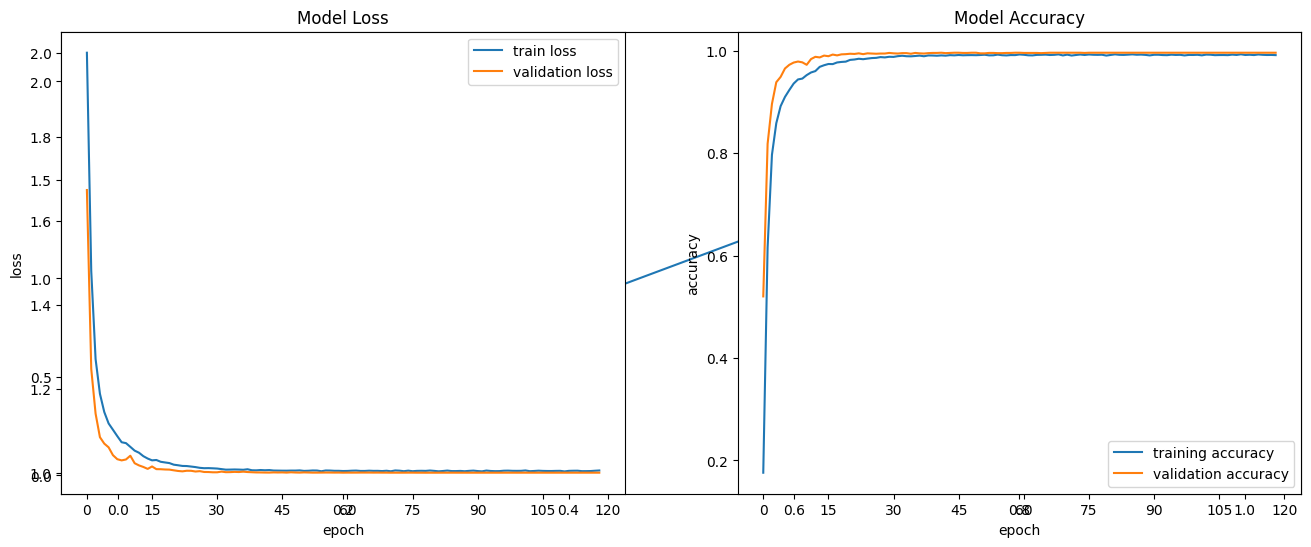

352/352 [==============================] - 50s 141ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.0140 - val_accuracy: 0.9964 - lr: 1.8458e-08
Epoch 120/300
 43/352 [==>...........................] - ETA: 39s - loss: 0.0168 - accuracy: 0.9949

In [ ]:
num_epochs = 300
pltCallBack = PlotLossAccuracy()
model.fit(X_train_spectrum, Y_train,
        batch_size=64, epochs=num_epochs,
        validation_data=(X_validation_spectrum, Y_validation),
        callbacks=[pltCallBack, c_schedule])


In [ ]:
model_1A =  # Figure this out
save_model_to_disk(model_1A, 'waveform_gender_model')

In [ ]:
model_1B = # Figure this out
save_model_to_disk(model_1B, 'waveform_digit_model')

In [19]:
model_2A =  # Figure this out
save_model_to_disk(model_2A, 'spectrogram_gender_model')

Saved model to spectrogram_gender_model.json and weights to spectrogram_gender_model.h5


In [31]:
model_2B = model# Figure this out
save_model_to_disk(model_2B, 'spectrogram_digit_model')

Saved model to spectrogram_digit_model.json and weights to spectrogram_digit_model.h5
